In [1]:
import dgl
import networkx as nx
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import hypertunity as ht
from sklearn import preprocessing

with open('/gpfs_home/spate116/data/spate116/GCN/E116/data/data_class1.pickle', 'rb') as f:
    data = pickle.load(f)

with open('/gpfs_home/spate116/data/spate116/GCN/E116/data/data1.pickle', 'rb') as f:
    data_reg = pickle.load(f)
    
with open('/gpfs_home/spate116/data/spate116/GCN/E116/data/data_class1_unflattened.pickle', 'rb') as f:
    data_unflattened = pickle.load(f)
    
edges = data.edge_index.t()
adj = list(map(lambda x: (x[0].item(), x[1].item()), edges))

graph = nx.read_gpickle("/gpfs_home/spate116/data/spate116/GCN/E116/data/graph.pickle")
weights = [x[2] for x in graph.edges.data('weight')]
robust_scaler = preprocessing.RobustScaler()
weights = np.ndarray.flatten(robust_scaler.fit_transform(np.array(weights).reshape(-1, 1)))

robust_scaler = preprocessing.RobustScaler()
shape = data_unflattened.x.shape
changed = np.array(data_unflattened.x).reshape(-1, 5)
transformed = robust_scaler.fit_transform(changed)
data_unflattened.x = torch.tensor(transformed, dtype=torch.float).reshape(shape)

G = dgl.DGLGraph(adj)
G.ndata['feat_unflattened'] = data_unflattened.x.reshape(data_unflattened.x.shape[0], 1, data_unflattened.x.shape[1], data_unflattened.x.shape[2]).float()
G.ndata['expr'] = torch.tensor(list(map(lambda x: x[0], data.y)), dtype=torch.long)
G.edata['weight'] = torch.tensor(weights, dtype=torch.float)

Using backend: pytorch


## Autoencoder

In [2]:
from pytorch_memlab import profile
class Autoencoder(nn.Module):
    def __init__(self, x):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, x, (3, 3)),
            nn.LeakyReLU(),
            nn.Dropout2d(),
            nn.Conv2d(x, 2*x, (3, 2)),
            nn.LeakyReLU(),
            nn.Dropout2d(),
            nn.Conv2d(2*x, 1, (3, 2)),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 2*x, (3, 2)),
            nn.LeakyReLU(),
            nn.Dropout2d(),
            nn.ConvTranspose2d(2*x, x, (3, 2)),
            nn.LeakyReLU(),
            nn.Dropout2d(),
            nn.ConvTranspose2d(x, 1, (3, 3)),
        )
    
    @profile
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)

In [3]:
import random
random.seed(30)
idx = list(range(len(G.nodes)))
random.shuffle(idx)
train_mask = idx[:10000]
test_mask = idx[10000:]

In [4]:
from tqdm import tqdm

device = torch.device('cuda')
def train_ae(net, data, epochs, lr, train_mask, test_mask):
    model = net.to(device)
    data = data.to(device)
    samples = len(data)
    correct = data.cpu().numpy().tolist()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    losses_train = []
    losses_test = []
    
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        model.train()
        res = model(data)
        loss = F.mse_loss(data[train_mask], res[train_mask])
        loss_test = F.mse_loss(data[test_mask], res[test_mask])
        
        losses_train.append(loss.item())
        losses_test.append(loss_test.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #scheduler.step(loss_test)

        pbar.set_description('Train Loss: %.4f | Test Loss: %.4f' % (loss.item(), loss_test.item()))
            
    return losses_train, losses_test, model

In [5]:
net = Autoencoder(120)

losses_train, losses_test, model = train_ae(net, G.ndata['feat_unflattened'], 2500, 0.001, train_mask, test_mask)

Train Loss: 0.3339 | Test Loss: 0.3379: 100%|██████████| 2500/2500 [1:33:38<00:00,  2.25s/it]


Text(0.5, 1.0, 'mse_loss')

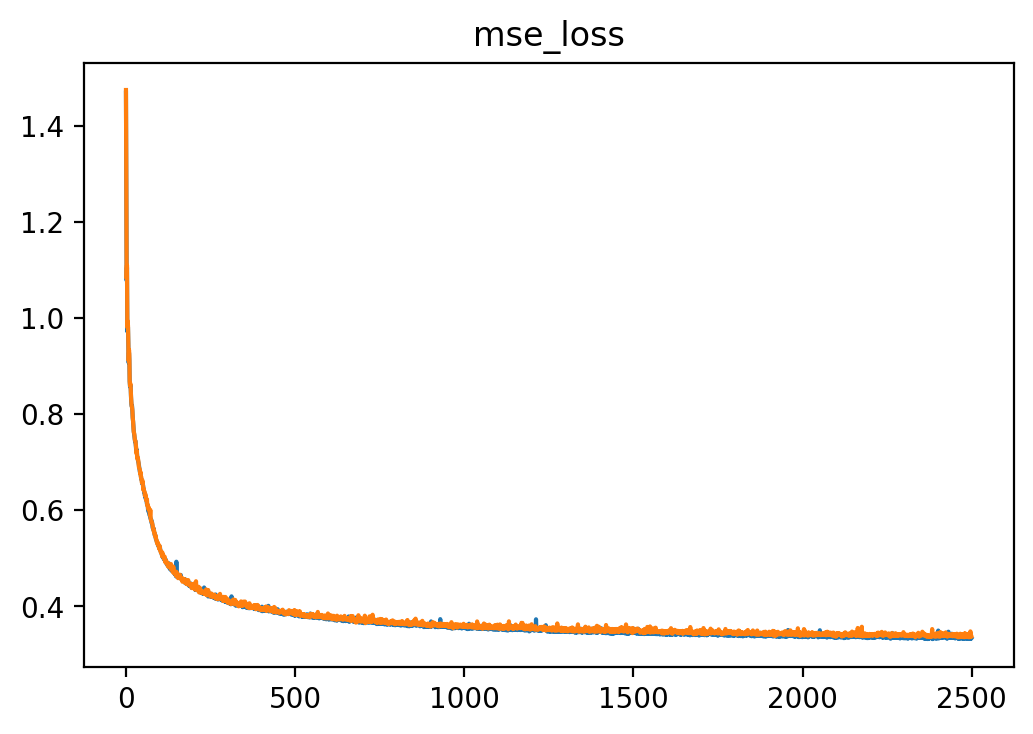

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('png')
matplotlib.rcParams['figure.dpi'] = 200

plot = sns.lineplot(x = range(len(losses_train)), y = losses_train)
sns.lineplot(x = range(len(losses_train)), y = losses_test)
plot.set_title("mse_loss")

In [7]:
res = model(G.ndata['feat_unflattened'].to(device)).cpu().detach()

In [8]:
import gif

@gif.frame
def showplt(i):
    fig, axs = plt.subplots(2)
    axs[0].imshow(G.ndata['feat_unflattened'][i].reshape(5, 100))
    axs[1].imshow(res[i].reshape(5, 100))
    
frames = []
for i in tqdm(range(200)):
    frame = showplt(i)
    frames.append(frame)

100%|██████████| 200/200 [02:07<00:00,  1.57it/s]


In [9]:
gif.save(frames[:200], "/gpfs_home/spate116/data/spate116/GCN/E116/res/plots/autoencoder.gif", duration=1000)

In [10]:
model.encode(G.ndata['feat_unflattened'].to(device)).cpu().detach()[0].shape

torch.Size([1, 94, 1])

In [11]:
torch.save(model, "/gpfs_home/spate116/data/spate116/GCN/E116/res/autoencoder.model")

In [12]:
import pickle
res_embedding = model.encode(G.ndata['feat_unflattened'].to(device)).cpu().detach().reshape(-1, 94)

with open('/gpfs_home/spate116/data/spate116/GCN/E116/data/data_embedding.pickle', 'wb') as f:
    pickle.dump(res_embedding, f)